# Quick implementation - motifs ordering

## Maria Inês Silva
## 28/01/2019

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
data_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data'))
output_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'outputs/experiments_v3'))

In [27]:
def load_motif_data(folder):
    ts_1d = pickle.load(open(os.path.join(folder, "ts_1d.p"), "rb"))
    mdl_cost_list = pickle.load(open(os.path.join(folder, "mdl_cost.p"), "rb"))
    motif_point_list = pickle.load(open(os.path.join(folder, "motif_point.p"), "rb"))
    motif_center_list = pickle.load(open(os.path.join(folder, "motif_center.p"), "rb"))
    pattern_list = pickle.load(open(os.path.join(folder, "patterns.p"), "rb"))
    mean_dist = pickle.load(open(os.path.join(folder, "mean_dist.p"), "rb"))
    return ts_1d, mdl_cost_list, motif_point_list, motif_center_list, pattern_list, mean_dist


def load_ts_data(folder):
    trip_df = pd.read_pickle(os.path.join(folder, 'trip_df.pkl'))
    multi_dim_ts = trip_df[['ay', 'az']]
    events_ts = trip_df['event_type']
    return multi_dim_ts, events_ts


def plot_zoomin_motif(ts, motif_index, motif_point_list, events_ts,  x_lim):
    motif_pointers = motif_point_list[motif_index]
    event_df = pd.DataFrame([ts, events_ts.values]).T.reset_index()
    event_df.columns = ['index', 'var', 'event']
    fig = plt.figure(figsize=(25,10))
    plt.subplot(3,1,1)
    plt.plot(ts, 'tab:gray')
    for temp_point in motif_pointers:
        plt.plot(temp_point, ts[temp_point], 'tab:blue')
    sns.scatterplot(x="index", y="var", hue="event", data=event_df[event_df['event']>0], legend=False,
                    palette=sns.xkcd_palette(['red', 'tangerine', 'greenish yellow']))
    plt.ylim(min(ts), max(ts))
    plt.xlim(x_lim)
    return fig

## Data import

In [4]:
multi_dim_ts, events_ts = load_ts_data(data_folder)

folder = os.path.join(output_folder, 'trip_exp2')
ts_1d, mdl_cost_list, motif_point_list, motif_center_list, pattern_list, mean_dist = load_motif_data(folder)

## Computing the events partition for each motif

In [5]:
def compute_event_partition(motif_point_list, events_ts):
    motif_event_partition_list = []
    for motif_point in motif_point_list:
        motif_events_dic_list = []
        for member in motif_point:
            member_events_list = [events_ts[i] for i in member]
            member_events_dic = {'brakes': np.sum([member_event==1 for member_event in member_events_list]),
                                 'turns': np.sum([member_event==2 for member_event in member_events_list]),
                                 'accelerations': np.sum([member_event==3 for member_event in member_events_list])}
            motif_events_dic_list.append(member_events_dic)
        motif_events_partition = pd.DataFrame(motif_events_dic_list).sum()
        if np.mean(motif_events_partition)==0:
            motif_events_partition['dispersion'] = 0
        else:
            motif_events_partition['dispersion'] = round(np.std(motif_events_partition)/float(np.mean(motif_events_partition)), 2)
        motif_event_partition_list.append(motif_events_partition)
    motif_partition_df = pd.DataFrame(motif_event_partition_list)
    return motif_partition_df

## Create motif table

In [6]:
def create_motif_table(pattern_list, motif_point_list, mdl_cost_list, mean_dist, events_ts):
    motif_dic = {'pattern' : pattern_list,
                 'pattern_len' : [len(pattern) for pattern in pattern_list],
                 'n_members' : [len(temp_motif) for temp_motif in motif_point_list],
                 'mdl_cost' : mdl_cost_list,
                 'mean_dist' : mean_dist}
    motif_partition_df = compute_event_partition(motif_point_list, events_ts)
    motif_df = pd.DataFrame(motif_dic) \
                        .join(motif_partition_df) \
                        .assign(mdl_cost = lambda x: x['mdl_cost'].round(1)) \
                        .sort_values('mdl_cost')
    return motif_df

In [7]:
motif_df = create_motif_table(pattern_list, motif_point_list, mdl_cost_list, mean_dist, events_ts)
motif_df.head()

,pattern,pattern_len,n_members,mdl_cost,mean_dist,accelerations,brakes,turns,dispersion
269,[ded],1,83,57437.7,0.059711,2.0,3.0,1.0,0.41
245,[cdd],1,85,57540.4,0.055325,1.0,2.0,0.0,0.82
80,[ddd],1,85,57560.0,0.052520,1.0,4.0,1.0,0.71
18,[ccd],1,86,57981.1,0.057987,2.0,3.0,0.0,0.75
182,[edd],1,78,58330.2,0.059818,2.0,3.0,1.0,0.41


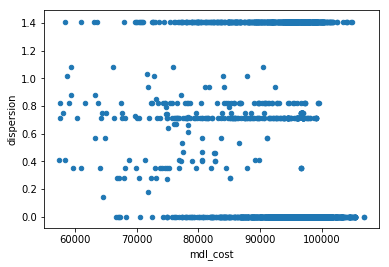

In [8]:
motif_df.plot.scatter('mdl_cost', 'dispersion')
plt.show()

In [9]:
max_brake = np.sum([event==1 for event in events_ts])
max_turn = np.sum([event==2 for event in events_ts])
max_acc = np.sum([event==3 for event in events_ts])
print(max_brake, max_turn, max_acc)

23 35 21


In [10]:
motif_df.sort_values('accelerations', ascending=False).head(10)

,pattern,pattern_len,n_members,mdl_cost,mean_dist,accelerations,brakes,turns,dispersion
46,[ede],1,56,63200.9,0.059932,5.0,2.0,0.0,0.88
129,[ddc],1,77,58679.7,0.059987,4.0,0.0,1.0,1.02
15,[edf],1,24,72746.7,0.066197,4.0,0.0,1.0,1.02
250,[bce],1,18,76492.4,0.085135,3.0,0.0,3.0,0.71
223,[aaa],1,19,74932.3,0.133900,3.0,3.0,13.0,0.74
21,[dfd],1,29,71886.0,0.072523,3.0,3.0,2.0,0.18
627,"[baa, aaa]",2,18,74739.3,0.174633,3.0,3.0,13.0,0.74
1592,"[baa, aaa, aab]",3,17,76118.7,0.192185,3.0,3.0,11.0,0.67
211,[eed],1,66,60318.7,0.059826,3.0,3.0,0.0,0.71
134,[eee],1,49,65027.0,0.054111,3.0,2.0,0.0,0.75


In [11]:
motif_df.sort_values('brakes', ascending=False).head(10)

,pattern,pattern_len,n_members,mdl_cost,mean_dist,accelerations,brakes,turns,dispersion
63,[cee],1,38,66119.4,0.068496,0.0,5.0,1.0,1.08
92,[cde],1,70,59286.1,0.068449,1.0,5.0,0.0,1.08
196,[dde],1,79,59314.2,0.058710,2.0,5.0,0.0,0.88
14,[dee],1,60,61632.9,0.059013,2.0,4.0,0.0,0.82
80,[ddd],1,85,57560.0,0.052520,1.0,4.0,1.0,0.71
31,[bdf],1,20,74979.1,0.106615,0.0,4.0,4.0,0.71
11,[cce],1,46,64513.3,0.076154,3.0,4.0,3.0,0.14
201,[dfe],1,32,69752.7,0.063002,3.0,4.0,0.0,0.73
1204,"[aaa, aab, aac]",3,13,78278.7,0.159617,2.0,3.0,9.0,0.66
2141,"[egg, fgg, ggg, ggf]",4,11,80546.7,0.220511,1.0,3.0,3.0,0.40


In [12]:
motif_df.sort_values('turns', ascending=False).head(10)

,pattern,pattern_len,n_members,mdl_cost,mean_dist,accelerations,brakes,turns,dispersion
627,"[baa, aaa]",2,18,74739.3,0.174633,3.0,3.0,13.0,0.74
223,[aaa],1,19,74932.3,0.133900,3.0,3.0,13.0,0.74
83,[baa],1,22,73162.6,0.143122,2.0,2.0,11.0,0.85
947,"[aaa, aab]",2,18,76309.0,0.167707,3.0,3.0,11.0,0.67
1592,"[baa, aaa, aab]",3,17,76118.7,0.192185,3.0,3.0,11.0,0.67
1204,"[aaa, aab, aac]",3,13,78278.7,0.159617,2.0,3.0,9.0,0.66
37,[fgg],1,29,71698.5,0.138452,1.0,1.0,9.0,1.03
2162,"[baa, aaa, aab, aac]",4,12,78265.6,0.147032,2.0,3.0,8.0,0.61
1850,"[caa, baa, aaa]",3,12,84940.1,0.205930,1.0,2.0,7.0,0.79
166,[egg],1,24,74681.9,0.214346,1.0,2.0,7.0,0.79


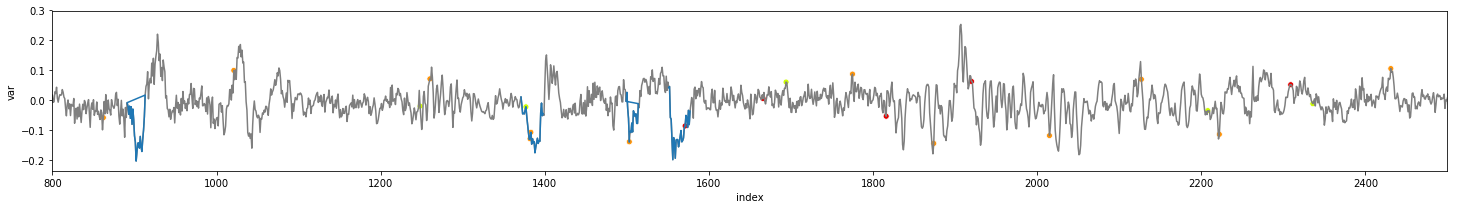

In [35]:
plot_zoomin_motif(ts_1d, 627, motif_point_list, events_ts,  [800, 2500])
plt.show()

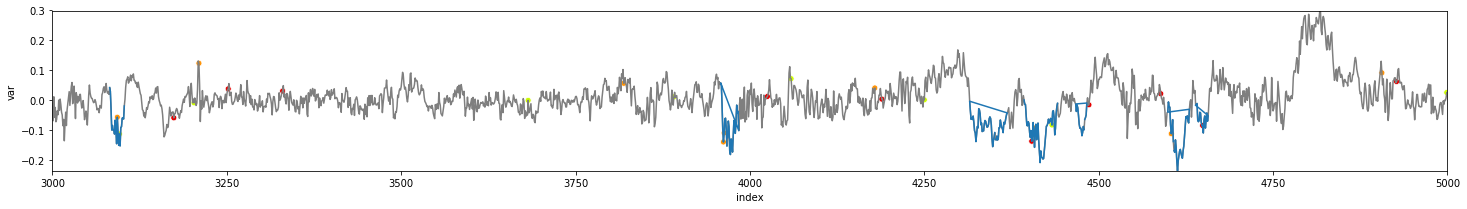

In [36]:
plot_zoomin_motif(ts_1d, 627, motif_point_list, events_ts,  [3000, 5000])
plt.show()

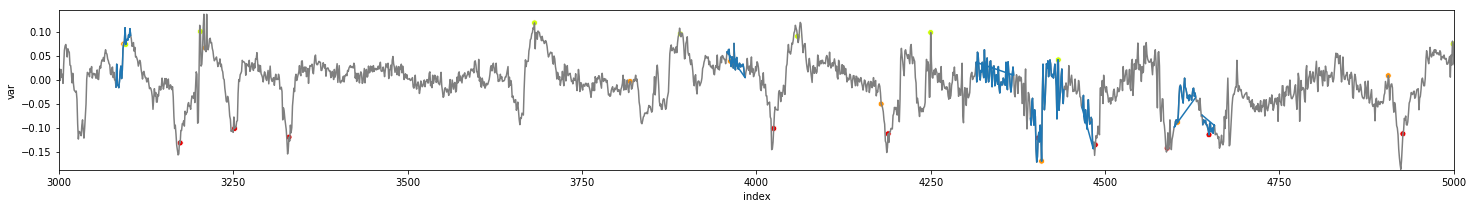

In [38]:
plot_zoomin_motif(multi_dim_ts['az'].values, 627, motif_point_list, events_ts,  [3000, 5000])
plt.show()

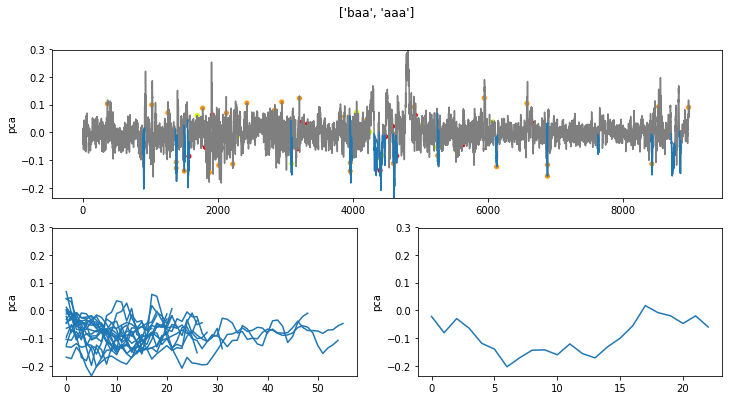

In [18]:
# extendedMD code
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
from extendedMD.motif_viz import plot_single_motif

plot_single_motif(ts_1d, events_ts, 627, motif_point_list, motif_center_list, pattern_list, 'pca')
plt.show()

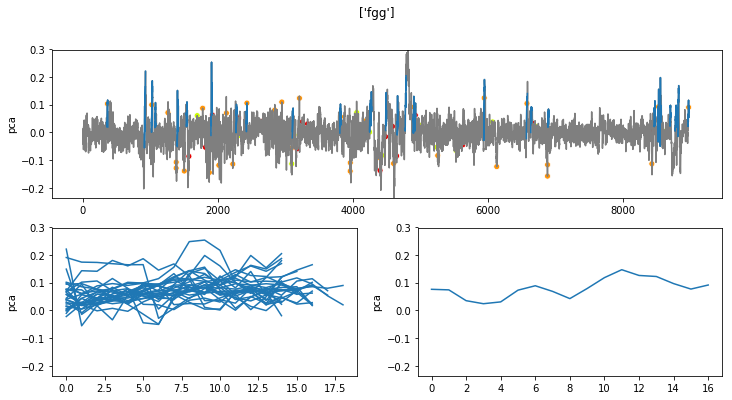

In [21]:
plot_single_motif(ts_1d, events_ts, 37, motif_point_list, motif_center_list, pattern_list, 'pca')
plt.show()